In [1]:
import sys
sys.path.append('../60_gebastel/Model/')
sys.path.append('../30_data_tools/')

In [59]:
from io import BytesIO
from pytorch_model_tools import get_datasets
from file_interaction import download_blob
from tqdm.auto import tqdm
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pickle
import math
import pandas as pd
import re
from helper import load_dotenv

In [60]:
dotenv = load_dotenv()

## noch offen

- ROC-Kurve/Area under Curve

0 = moire, 1 = no moire

In [4]:
def load_data( model_results_name ):
    data = pickle.loads( download_blob(f'model_results/{ model_results_name }.pkl').getbuffer() )
    data.rename(columns={'category':'label'}, inplace=True)
    
    data.loc[:,'predicted_label'] = (data.result_moire < data.result_no_moire).astype('int').apply(lambda val: ['moire','no_moire'][val])
    data.loc[:,'classification_correct'] = data.predicted_label == data.label

    data = pd.merge(
        data,
        data.tile_name.str.extract('(.+)_(\d+)\.\d+\.jpg').rename(columns={0:'mask_id',1:'dpi'}),
        left_index=True,
        right_index=True
    )
    
    return data

In [5]:
def calc_metrics( data ):
    TP = data.loc[(data.label == 'moire') & (data.predicted_label == 'moire')].shape[0]
    TN = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'no_moire')].shape[0]
    FP = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'moire')].shape[0]
    FN = data.loc[(data.label == 'moire') & (data.predicted_label == 'no_moire')].shape[0]

    out = {
        "count_data" : data.shape[0],
        "TP" : TP,
        "TN" : TN,
        "FP" : FP,
        "FN" : FN,
        "TN-Rate" : 0,
        "TP-Rate" : 0,
        "accuracy" : 0,
        "precision" : 0,
        "recall" : 0
    }
    
    if (FP + TN) > 0:
        out["TN-Rate"] = TN / (FP + TN)

    if (FN + TP) > 0:
        out["TP-Rate"] = TP / (FN + TP)

    if out['count_data'] > 0:
        out["accuracy"] = (TP + TN) / out['count_data']

    if (TP + FP) > 0:
        out["precision"] = TP / (TP + FP)

    if (TP + FN) > 0:
        out["recall"] = TP / (TP + FN)
    

    return out

In [6]:
def get_confusion_matrix( metrics, relative=False ):
    values = np.array([
        [metrics['TP'],metrics['FN']],
        [metrics['FP'],metrics['TN']]
    ])

    if relative:
        values = values / metrics['count_data']
    
    return px.imshow(
        values,
        x=['moire','no_moire'],
        y=['moire','no_moire'],
        labels={
            'y' : 'label',
            'x' : 'prediction'
        },
        text_auto=True
    )

In [7]:
model_name = '2024-05-02_Resnet50_002'
dataset_name = '24-05-02_001_tile_dataset'

In [8]:
data = load_data(f"{ model_name }_{ dataset_name }")

In [9]:
metrics = {}

for dataset in data.dataset.unique():
    metrics[dataset] = calc_metrics( data.loc[data.dataset == dataset] )

In [10]:
metrics_df = pd.DataFrame.from_dict([metrics[key] for key in metrics])
metrics_df.loc[:,'dataset'] = [key for key in metrics]
metrics_df.set_index('dataset', inplace=True)

metrics_df.T

dataset        real_val          test         train           val
count_data  7440.000000  30852.000000  90487.000000  13564.000000
TP          2321.000000  10699.000000  33300.000000   4142.000000
TN          1948.000000  14908.000000  45736.000000   6689.000000
FP           784.000000   2820.000000   7600.000000   1239.000000
FN          2387.000000   2425.000000   3851.000000   1494.000000
TN-Rate        0.713031      0.840930      0.857507      0.843718
TP-Rate        0.492991      0.815224      0.896342      0.734918
accuracy       0.573790      0.829995      0.873451      0.798511
precision      0.747504      0.791405      0.814181      0.769745
recall         0.492991      0.815224      0.896342      0.734918

In [ ]:
get_confusion_matrix( metrics['train'], relative=True )

In [ ]:
get_confusion_matrix( metrics['test'], relative=True )

In [ ]:
get_confusion_matrix( metrics['val'], relative=True )

In [ ]:
get_confusion_matrix( metrics['real_val'], relative=True )

In [38]:
def get_roc( data, threshold ):
    selection_moire = data.loc[data.result_moire > threshold]
    selection_no_moire = data.loc[data.result_moire <= threshold]
    TP = selection_moire.loc[selection_moire.label == 'moire'].shape[0]
    FP = selection_moire.loc[selection_moire.label == 'no_moire'].shape[0]
    TN = selection_no_moire.loc[selection_no_moire.label == 'no_moire'].shape[0]
    FN = selection_no_moire.loc[selection_no_moire.label == 'moire'].shape[0]

    TP_rate = TP / (TP + FN)
    FP_rate = FP / (FP + TN)

    return TP_rate, FP_rate


(0.8436958709315561, 0.1711981792374333)

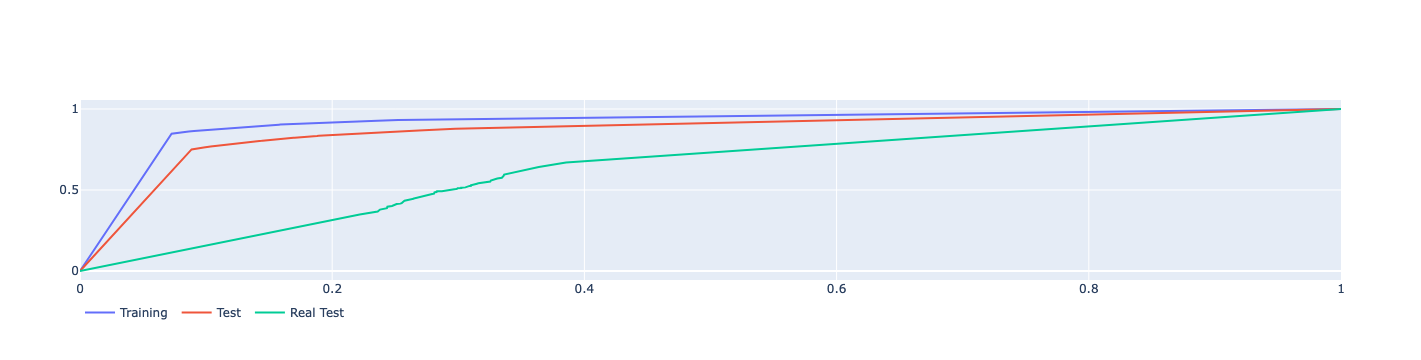

In [48]:
fig = go.Figure()

roc_train = [get_roc(data.loc[data.dataset == 'train'], i / 100) for i in range(101)]
roc_test = [get_roc(data.loc[data.dataset == 'test'], i / 100) for i in range(101)]
roc_real_val = [get_roc(data.loc[data.dataset == 'real_val'], i / 100) for i in range(101)]

fig.add_trace(go.Scatter(
    x=[r[1] for r in roc_train],
    y=[r[0] for r in roc_train],
    mode="lines",
    name="Training"
))
fig.add_trace(go.Scatter(
    x=[r[1] for r in roc_test],
    y=[r[0] for r in roc_test],
    mode="lines",
    name="Test"
))
fig.add_trace(go.Scatter(
    x=[r[1] for r in roc_real_val],
    y=[r[0] for r in roc_real_val],
    mode="lines",
    name="Real Test"
))
fig.update_layout(legend={'orientation':'h'})

fig

# Kacheldataset

In [ ]:
tile_dataset = pd.merge(
    data,
    data.tile_name.str.extract('(.+)_(\d+)\.\d+\.jpg').rename(columns={0:'mask_id',1:'dpi'}),
    left_index=True,
    right_index=True
)

In [ ]:
grouped_tile_dataset = tile_dataset.loc[
    :,
    ['mask_id','dataset','label','dpi','predicted_label']
].groupby(['mask_id','label','dpi']).min().reset_index()
grouped_tile_dataset = grouped_tile_dataset.groupby(['mask_id','label']).agg(pd.Series.mode).reset_index().drop(columns=['dpi'])
grouped_tile_dataset = grouped_tile_dataset.loc[
    grouped_tile_dataset.predicted_label.apply(lambda val: type(val) == str)
]

In [ ]:
tile_metrics_df = pd.DataFrame.from_dict([calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == dataset]) for dataset in grouped_tile_dataset.dataset.unique()])
tile_metrics_df.loc[:,'dataset'] = [key for key in metrics]
tile_metrics_df.set_index('dataset', inplace=True)

tile_metrics_df.T

In [ ]:
calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'test'])

In [ ]:
calc_metrics( data.loc[data.dataset == 'real_val'] )

In [ ]:
calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'test'])

In [ ]:
calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'real_val'])

# Datenset nach Auflösung

In [28]:
resolution_metrics = []

for dataset in ['test','real_val']:
    for resolution in data.loc[pd.isna(data.dpi) == False].dpi.unique():
        resolution_metric = calc_metrics(
            data.loc[
                (data.dataset == dataset) &
                (data.dpi == resolution)
            ]
        )

        resolution_metric['dataset'] = dataset
        resolution_metric['resolution'] = resolution
        resolution_metrics.append(resolution_metric)

In [29]:
resolution_metrics_df = pd.DataFrame.from_dict(resolution_metrics)
resolution_metrics_df.set_index(['dataset','resolution'], inplace=True)
resolution_metrics_df

count_data    TP    TN   FP    FN   TN-Rate   TP-Rate  \
dataset  resolution                                                          
test     300              15134  6034  6927  640  1533  0.915422  0.797410   
         200               7006  2906  2787  716   597  0.795604  0.829575   
         150               4108  1759  1365  689   295  0.664557  0.856378   
real_val 300               3606   945   856  100  1705  0.895397  0.356604   
         200               2181   734   650  246   551  0.725446  0.571206   
         150               1653   642   442  438   131  0.502273  0.830530   

                     accuracy  precision    recall  
dataset  resolution                                 
test     300         0.856416   0.904105  0.797410  
         200         0.812589   0.802319  0.829575  
         150         0.760467   0.718546  0.856378  
real_val 300         0.499445   0.904306  0.356604  
         200         0.634571   0.748980  0.571206  
         150         0.655777   0.594444  0.830530

# Rest

In [49]:
from PIL import Image
from PIL import ImageFont, ImageDraw  
from pathlib import Path

In [65]:
result

tile_name                 TY9ECj6DfD_ok_sample_300.0002.jpg
label                                              no_moire
dataset                                            real_val
result_moire                                        0.00041
result_no_moire                                     0.99959
predicted_label                                    no_moire
classification_correct                                 True
mask_id                                TY9ECj6DfD_ok_sample
dpi                                                     300
Name: 0, dtype: object

In [64]:
result = data.iloc[0]

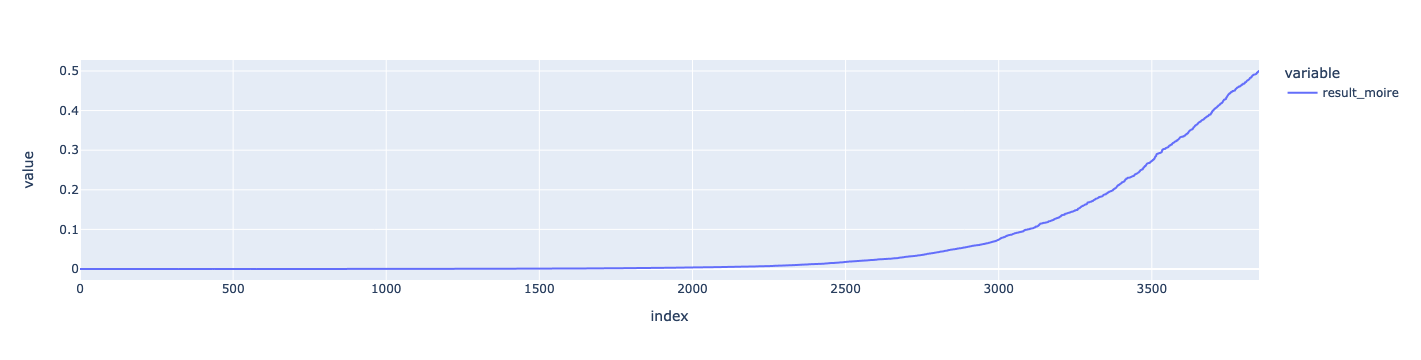

In [128]:
px.line(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'no_moire') &
        (data.dataset == 'train')
    ].sort_values('result_moire').reset_index().result_moire
)

In [133]:
data.loc[
    (data.label == 'moire') &
    (data.predicted_label == 'moire') &
    (data.dataset == 'train')
].sort_values('result_moire', ascending=False).iloc[:50]

tile_name  label dataset  result_moire  result_no_moire  \
91628   WOCjIWdocN_300.0011.jpg  moire   train           1.0     2.114206e-09   
113716  zsQJvAgwA8_300.0154.jpg  moire   train           1.0     1.609824e-21   
113726  M__MFzWcFN_200.0052.jpg  moire   train           1.0     3.287092e-21   
113725  e5T2dsihnj_300.0101.jpg  moire   train           1.0     2.839765e-13   
113724  _FDpFcpHlt_300.0236.jpg  moire   train           1.0     2.163628e-10   
113723  AY-pDnOpW7_200.0245.jpg  moire   train           1.0     5.374914e-17   
113722  zsQJvAgwA8_300.0140.jpg  moire   train           1.0     8.108043e-13   
113721  JhkWO6oQEf_300.0070.jpg  moire   train           1.0     9.536254e-14   
113720  uTyXzfcnQW_150.0046.jpg  moire   train           1.0     3.627881e-11   
113719  SkhMBKLhPT_300.0000.jpg  moire   train           1.0     1.335167e-08   
113718  M__MFzWcFN_200.0046.jpg  moire   train           1.0     3.022557e-35   
113717  e5T2dsihnj_300.0115.jpg  moire   train           1.0     1.051720e-15   
113715  AY-pDnOpW7_200.0251.jpg  moire   train           1.0     1.118798e-15   
113730  JhkWO6oQEf_300.0064.jpg  moire   train           1.0     6.213061e-09   
113710  TV_2Btxq8T_200.0249.jpg  moire   train           1.0     4.031038e-15   
113705  qIWywYS_hn_200.0237.jpg  moire   train           1.0     5.873883e-14   
113704  Teoc9kTkyh_300.0020.jpg  moire   train           1.0     8.932156e-14   
113702  DaZzNpOjLJ_200.0051.jpg  moire   train           1.0     4.646757e-10   
113701  3RAjxMkw2q_300.0088.jpg  moire   train           1.0     6.078351e-11   
113699  v1sKiWpQLL_300.0001.jpg  moire   train           1.0     1.765496e-08   
113697  New9PhXbIC_200.0152.jpg  moire   train           1.0     1.515848e-08   
113696  qIWywYS_hn_300.0139.jpg  moire   train           1.0     4.573424e-18   
113694  3EPgXu_2Qh_300.0104.jpg  moire   train           1.0     6.808286e-15   
113692  FHBKGdb6aD_200.0139.jpg  moire   train           1.0     4.084120e-19   
113728  SkhMBKLhPT_300.0014.jpg  moire   train           1.0     8.988733e-16   
113731  LEYg0e_jpy_300.0048.jpg  moire   train           1.0     5.054409e-10   
113599  ia2l8w3nso_150.0146.jpg  moire   train           1.0     2.039503e-10   
113759  b-vTg9HiWx_200.0041.jpg  moire   train           1.0     2.943384e-14   
113772  e5T2dsihnj_200.0227.jpg  moire   train           1.0     2.746506e-16   
113771  ZnsYkhraiH_300.0015.jpg  moire   train           1.0     4.641300e-18   
113768  06sOQxHNAL_150.0180.jpg  moire   train           1.0     5.747223e-18   
113767  sCKibDTL_D_300.0063.jpg  moire   train           1.0     1.329424e-27   
113766  3EPgXu_2Qh_300.0138.jpg  moire   train           1.0     2.261181e-23   
113765  qIWywYS_hn_300.0105.jpg  moire   train           1.0     1.088671e-10   
113764  ONXfnItgMU_300.0080.jpg  moire   train           1.0     5.383565e-09   
113763  _M3kOL_0QW_300.0009.jpg  moire   train           1.0     2.707219e-15   
113761  pUbLPVC16M_200.0021.jpg  moire   train           1.0     3.029172e-12   
113760  DVGUM12_cw_200.0122.jpg  moire   train           1.0     5.847416e-13   
113755  EJYMRbWyrN_150.0145.jpg  moire   train           1.0     3.495010e-13   
113733  u0L1ejMoX8_200.0051.jpg  moire   train           1.0     2.638478e-17   
113754  3iwirnk_Tv_200.0074.jpg  moire   train           1.0     2.134762e-13   
113753  v1sKiWpQLL_300.0015.jpg  moire   train           1.0     1.069602e-17   
113752  cr4wJ1NzsD_200.0068.jpg  moire   train           1.0     2.957715e-12   
113751  TV_2Btxq8T_300.0153.jpg  moire   train           1.0     5.171504e-08   
113750  UMdBM77bQq_300.0009.jpg  moire   train           1.0     6.134813e-16   
113748  3EPgXu_2Qh_300.0110.jpg  moire   train           1.0     3.066901e-20   
113746  New9PhXbIC_150.0225.jpg  moire   train           1.0     3.421507e-12   
113740  __DgcOXDEJ_300.0061.jpg  moire   train           1.0     2.930514e-27   
113739  qIWywYS_hn_200.0223.jpg  moire   train       

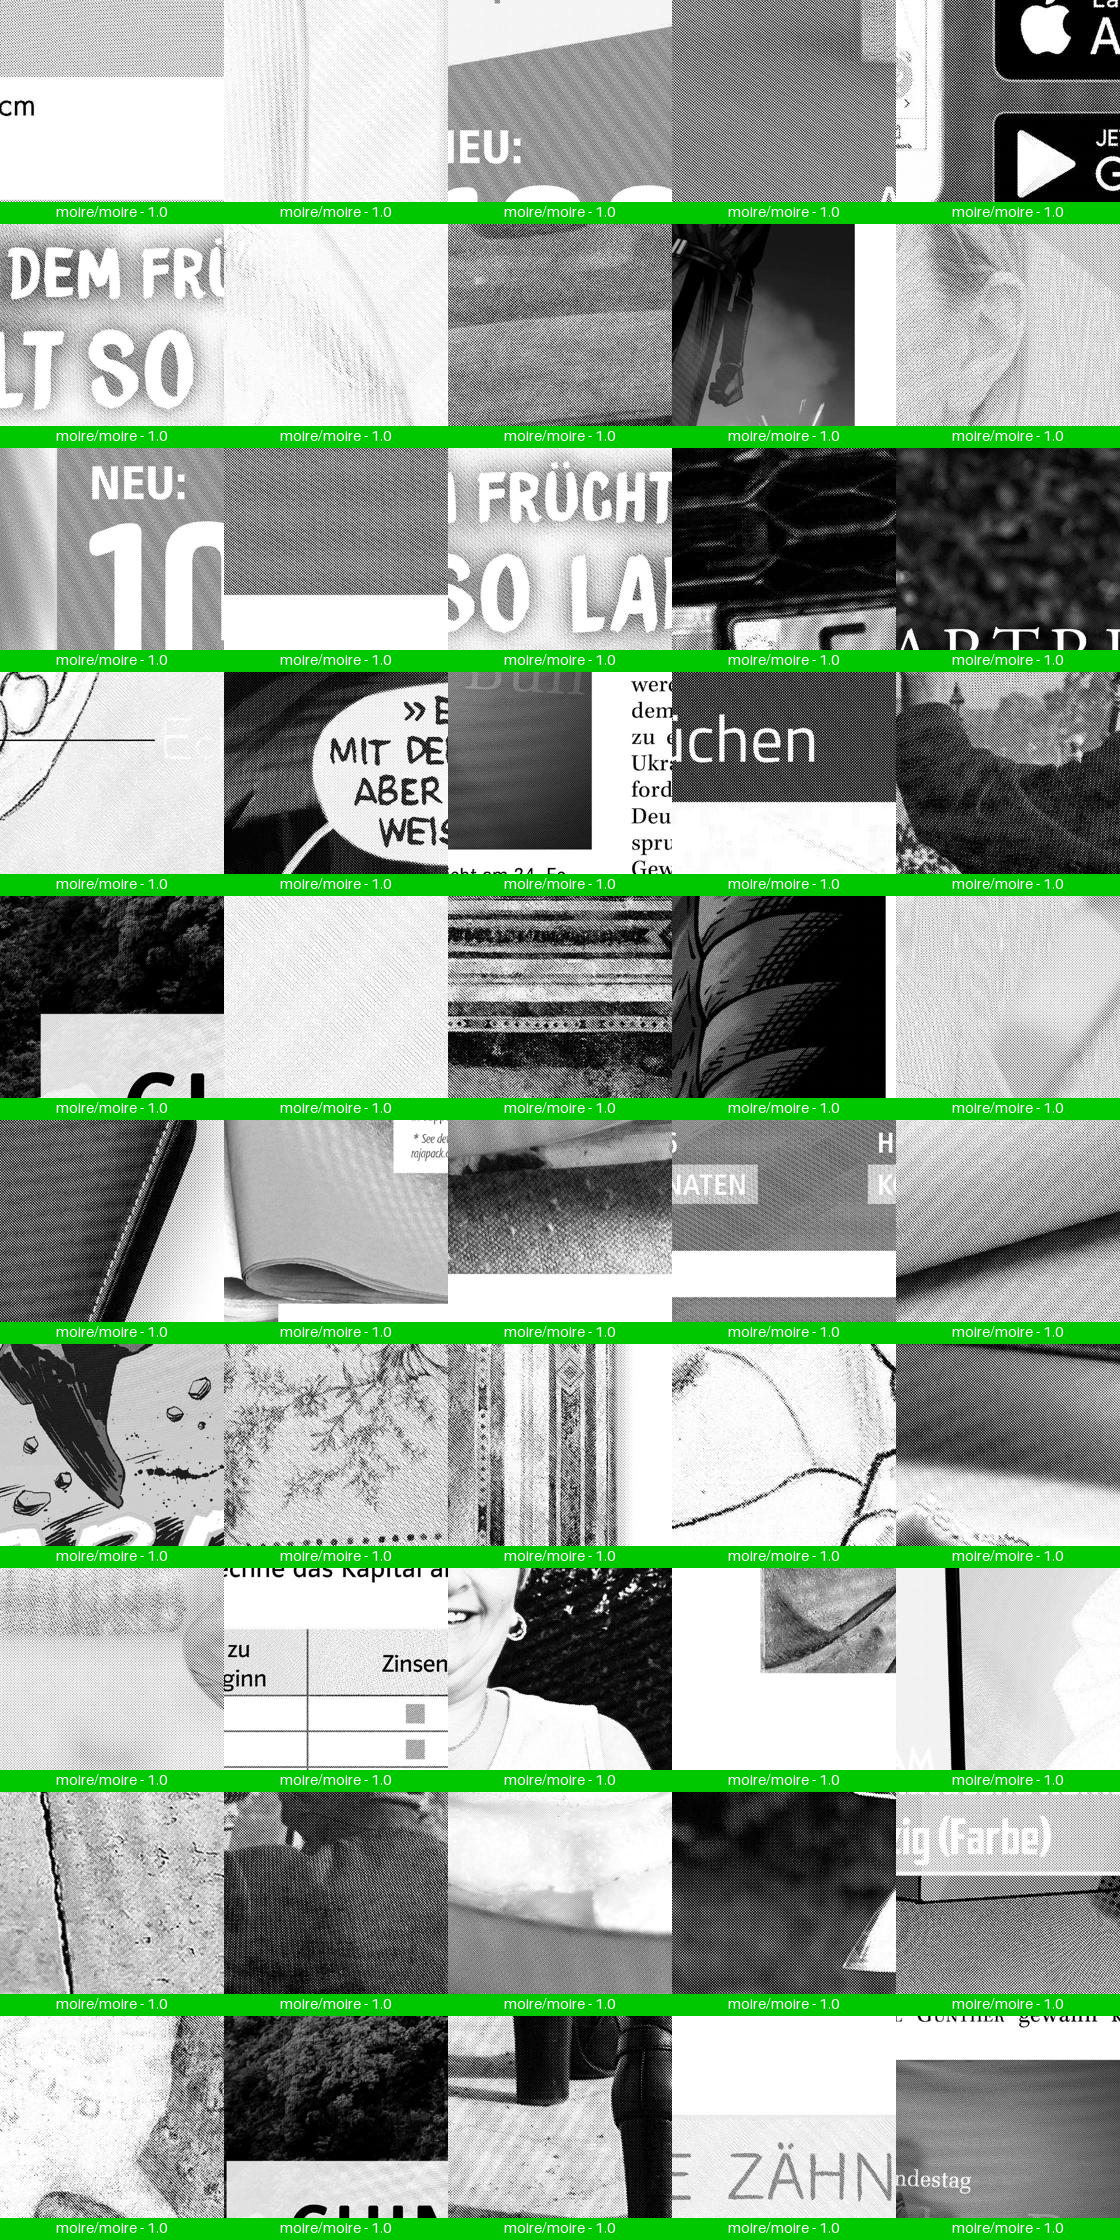

In [134]:
get_tile_result_grid(
    data.loc[
        (data.label == 'moire') &
        (data.predicted_label == 'moire') &
        (data.dataset == 'train')
    ].sort_values('result_moire', ascending=False).iloc[:50],
)

In [112]:
def get_tile_result_grid( data, img_size=224, col_count=5, label_type='both' ):
    label_names = ['moire','no_moire']
    row_count = math.ceil(data.shape[0] / col_count)

    out_img = Image.new(
        'RGB',
        (img_size * col_count, img_size * row_count),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]

    for i in range(data.shape[0]):
        row = i // col_count
        col = i % col_count

        result = data.iloc[i]
        tile_path = dotenv['TILE_DATASET_DIR'] / dataset_name / result.dataset / result.label / result.tile_name
        tile_img = Image.open( tile_path )
        out_img.paste(
            tile_img,
            ( col * tile_img.size[0], row * tile_img.size[1] )
        )
        draw.rectangle(
            (
                ( col * tile_img.size[0], row * tile_img.size[1] + round(img_size * 0.9) ),
                ( col * tile_img.size[0] + img_size, row * tile_img.size[1] + img_size )
            ),
            outline=None,
            fill=label_color[0] if result.classification_correct else label_color[1]
        )

        if label_type == 'label_name':
            label_text = f'{ result.predicted_label }/{ result.label }'
        elif label_type == 'moire_value':
            label_text = str( round(result.result_moire, 5) )
        else:
            label_text = f'{ result.predicted_label }/{ result.label } - {round(result.result_moire, 5)}'
        
        draw.text(
            ( col * tile_img.size[0] + round(img_size * 0.5), row * tile_img.size[1] + round(img_size * 0.97) ),
            label_text,
            anchor='ms',
            font_size=15
        )
    
    return out_img

In [ ]:
results = []

for tile_path in tqdm(tile_paths):
    tile = Image.open(tile_path)
    transform = transforms.Compose([transforms.PILToTensor()])

    tensor = transform(tile) / 255
    tensor = tensor.reshape((1,3,224,224))
    with torch.no_grad():
        pred = model(tensor)

    results.append((
        tile_path,
        pred,
        int(torch.argmax(pred))
    ))

In [ ]:
font = ImageFont.load_default()

In [ ]:
IMG_SIZE = 224

label_names = ['moire','no_moire']
grid_size = (5,5)

offset = 0

while offset < len(results):
    out_img = Image.new(
        'RGB',
        (IMG_SIZE * grid_size[0], IMG_SIZE * grid_size[1]),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]
    
    for y in range(grid_size[1]):
        for x in range(grid_size[0]):
            i = y * grid_size[1] + x
    
            if len(results) > offset + i:
                result = results[offset+i]
                label = result[0].parent.name
                target_label = label_names[result[2]]
                
                tile_img = Image.open( result[0] )
                out_img.paste(
                    tile_img,
                    ( x * tile_img.size[0], y * tile_img.size[1] )
                )
                draw.rectangle(
                    (
                        ( x * tile_img.size[0], y * tile_img.size[1] + round(IMG_SIZE * 0.9) ),
                        ( x * tile_img.size[0] + IMG_SIZE, y * tile_img.size[1] + IMG_SIZE )
                    ),
                    outline=None,
                    fill=label_color[0] if label == target_label else label_color[1]
                )
                draw.text(
                    ( x * tile_img.size[0] + round(IMG_SIZE * 0.5), y * tile_img.size[1] + round(IMG_SIZE * 0.97) ),
                    f'{ label }/{ target_label }',
                    anchor='ms',
                    font_size=15
                )
                
    offset += 50
    out_img.save( f'/Users/frederic.birwe/Downloads/tile_grid_{ (str(offset)).zfill(3) }.jpg' )

out_img

In [ ]:
results